# Analyse des données Olist
Ce notebook présente une analyse structurée des données Olist en utilisant des fonctions modulaires.

## 1. Imports et Configuration

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline
sns.set(style="whitegrid")

ModuleNotFoundError: No module named 'pandas'

## 2. Définition des Fonctions

In [ ]:
def load_data(data_dir='/content/'):
    """Charge les datasets Olist depuis le répertoire spécifié."""
    datasets = {
        'customers': 'olist_customers_dataset.csv',
        'geolocation': 'olist_geolocation_dataset.csv',
        'order_items': 'olist_order_items_dataset.csv',
        'order_payments': 'olist_order_payments_dataset.csv',
        'order_reviews': 'olist_order_reviews_dataset.csv',
        'orders': 'olist_orders_dataset.csv',
        'products': 'olist_products_dataset.csv',
        'sellers': 'olist_sellers_dataset.csv',
        'product_category': 'product_category_name_translation.csv'
    }

    data = {}
    for name, filename in datasets.items():
        path = os.path.join(data_dir, filename)
        if os.path.exists(path):
            data[name] = pd.read_csv(path)
            print(f'Chargé : {name} ({data[name].shape[0]} lignes)')
        else:
            print(f'Attention : Le fichier {path} n existe pas.')
            data[name] = None

    return data

In [ ]:
def cleaning(data):
    """Nettoie les données Olist."""
    # 1. Nettoyage Customers
    if data['customers'] is not None:
        data['customers'] = data['customers'].drop_duplicates(subset=['customer_unique_id'], keep='first')

    # 2. Nettoyage Orders
    if data['orders'] is not None:
        date_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date',
                     'order_delivered_customer_date', 'order_estimated_delivery_date']
        for col in date_cols:
            data['orders'][col] = pd.to_datetime(data['orders'][col], errors='coerce')

    # 3. Nettoyage Products
    if data['products'] is not None:
        data['products']['product_category_name'] = data['products']['product_category_name'].fillna('unknown')
        num_cols = ['product_name_lenght', 'product_description_lenght', 'product_photos_qty',
                    'product_weight_g', 'product_length_cm', 'product_height_cm', 'product_width_cm']
        data['products'][num_cols] = data['products'][num_cols].fillna(0)

    # 4. Nettoyage Reviews
    if data['order_reviews'] is not None:
        data['order_reviews']['review_comment_title'] = data['order_reviews']['review_comment_title'].fillna('No Title')
        data['order_reviews']['review_comment_message'] = data['order_reviews']['review_comment_message'].fillna('No Comment')
        data['order_reviews'] = data['order_reviews'].drop_duplicates(subset=['review_id'], keep='first')

    # 5. Nettoyage Order Items
    if data['order_items'] is not None:
        data['order_items']['shipping_limit_date'] = pd.to_datetime(data['order_items']['shipping_limit_date'])

    # 6. Nettoyage Payments
    if data['order_payments'] is not None:
        data['order_payments'] = data['order_payments'].drop_duplicates()

    # 7. Nettoyage Sellers
    if data['sellers'] is not None:
        data['sellers'] = data['sellers'].drop_duplicates(subset=['seller_id'])

    # 8. Nettoyage Geolocation
    if data['geolocation'] is not None:
        geo = data['geolocation'].drop_duplicates()
        geo = geo.dropna(subset=['geolocation_lat', 'geolocation_lng'])
        data['geolocation'] = geo.groupby('geolocation_zip_code_prefix').agg({
            'geolocation_lat': 'median',
            'geolocation_lng': 'median',
            'geolocation_city': 'first',
            'geolocation_state': 'first'
        }).reset_index()

    print('Nettoyage terminé.')
    return data

In [ ]:
def calculate_kpis(data):
    """Calcule les KPIs principaux (CA mensuel, Top produits, RFM)."""
    kpis = {}

    # Préparation du DataFrame principal (Orders + Items)
    df = data['orders'].merge(data['order_items'], on='order_id', how='inner')
    df = df[df['order_status'] == 'delivered']
    df['ca'] = df['price'] + df['freight_value']

    # 1. CA Mensuel
    df['year_month'] = df['order_purchase_timestamp'].dt.to_period('M')
    ca_monthly = df.groupby('year_month', as_index=False)['ca'].sum().sort_values('year_month')
    ca_monthly['ca_n_1'] = ca_monthly['ca'].shift(12)
    ca_monthly['variation_pct'] = ((ca_monthly['ca'] - ca_monthly['ca_n_1']) / ca_monthly['ca_n_1']) * 100
    ca_monthly['year_month_str'] = ca_monthly['year_month'].astype(str)
    kpis['ca_monthly'] = ca_monthly

    # 2. Top 10 Produits
    top_products = df.groupby('product_id', as_index=False).agg(ca=('ca', 'sum')).sort_values('ca', ascending=False).head(10)
    kpis['top_products'] = top_products

    # 3. Top 5 Catégories
    df_cat = df.merge(data['products'][['product_id', 'product_category_name']], on='product_id', how='left')
    df_cat = df_cat.merge(data['product_category'], on='product_category_name', how='left')
    top_5_categories = df_cat.groupby('product_category_name_english', as_index=False).agg(ca=('ca', 'sum')).sort_values('ca', ascending=False).head(5)
    kpis['top_5_categories'] = top_5_categories

    # 4. RFM
    df_rfm = df.merge(data['customers'][['customer_id', 'customer_unique_id']], on='customer_id', how='left')
    ref_date = df_rfm['order_purchase_timestamp'].max()
    rfm = df_rfm.groupby('customer_unique_id').agg(
        recency=('order_purchase_timestamp', lambda x: (ref_date - x.max()).days),
        frequency=('order_id', 'nunique'),
        monetary=('ca', 'sum')
    ).reset_index()

    # Scoring RFM
    for col, score_name in zip(['recency', 'frequency', 'monetary'], ['R_score', 'F_score', 'M_score']):
        try:
            rfm[score_name] = pd.qcut(rfm[col], q=5, labels=False, duplicates='drop') + 1
            if score_name == 'R_score':
                rfm[score_name] = 6 - rfm[score_name]
        except:
            rfm[score_name] = 1

    rfm['RFM_score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)
    kpis['rfm'] = rfm

    # 5. Heatmap Data
    df['month'] = df['order_purchase_timestamp'].dt.month
    df['weekday'] = df['order_purchase_timestamp'].dt.day_name()
    heatmap_data = df.groupby(['weekday', 'month'])['ca'].sum().reset_index()
    days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    heatmap_pivot = heatmap_data.pivot(index='weekday', columns='month', values='ca').reindex(days_order)
    kpis['heatmap_pivot'] = heatmap_pivot

    print('Calcul des KPIs terminé.')
    return kpis

In [ ]:
def display_kpis(kpis):
    """Affiche les KPIs sous forme de tableaux et résumés."""
    from IPython.display import display, Markdown

    display(Markdown('### 📊 Résumé des Indicateurs Clés (KPIs)'))

    display(Markdown('#### Top 5 des mois avec le plus gros CA'))
    display(kpis['ca_monthly'].sort_values('ca', ascending=False).head(5)[['year_month_str', 'ca', 'variation_pct']])

    display(Markdown('#### Top 5 des produits les plus rentables'))
    display(kpis['top_products'].head(5))

    display(Markdown('#### Top 5 des catégories les plus vendues'))
    display(kpis['top_5_categories'])

    display(Markdown('#### Statistiques RFM Moyennes'))
    display(kpis['rfm'][['recency', 'frequency', 'monetary']].mean().to_frame('Moyenne'))

In [ ]:
def visualize_data(kpis):
    """Génère les visualisations à partir des KPIs."""
    # 1. CA Mensuel
    plt.figure(figsize=(12,6))
    ca_monthly = kpis['ca_monthly']
    ca_monthly['year_month_dt'] = pd.to_datetime(ca_monthly['year_month_str'])
    ca_monthly['ca_ma3'] = ca_monthly['ca'].rolling(window=3).mean()

    plt.plot(ca_monthly['year_month_dt'], ca_monthly['ca'], marker='o', label='CA mensuel')
    plt.plot(ca_monthly['year_month_dt'], ca_monthly['ca_ma3'], color='red', linestyle='--', label='Moyenne mobile 3 mois')
    plt.title('Chiffre d’affaires mensuel + Moyenne mobile 3 mois')
    plt.xlabel('Mois')
    plt.ylabel('CA (BRL)')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # 2. Top 10 Produits
    plt.figure(figsize=(12,6))
    top_products = kpis['top_products']
    plt.bar(top_products['product_id'], top_products['ca'], color='skyblue')
    plt.title('Top 10 produits par chiffre d’affaires')
    plt.xlabel('Product ID')
    plt.ylabel('CA (BRL)')
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # 3. Heatmap
    plt.figure(figsize=(12,6))
    sns.heatmap(kpis['heatmap_pivot'], cmap='YlGnBu', annot=True, fmt='.0f')
    plt.title('Heatmap CA par jour de semaine et mois')
    plt.xlabel('Mois')
    plt.ylabel('Jour de semaine')
    plt.tight_layout()
    plt.show()

    # 4. Distribution RFM
    plt.figure(figsize=(10,6))
    plt.hist(np.log1p(kpis['rfm']['monetary']), bins=30, color='skyblue', edgecolor='black')
    plt.title('Distribution de la valeur monétaire par client (log1p)')
    plt.xlabel('log(CA par client + 1)')
    plt.ylabel('Nombre de clients')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## 3. Exécution du Pipeline

In [ ]:
# 1. Chargement (ajustez le chemin si nécessaire)
data = load_data('/content/')

Chargé : customers (99441 lignes)
Chargé : geolocation (1000163 lignes)
Chargé : order_items (112650 lignes)
Chargé : order_payments (103886 lignes)
Chargé : order_reviews (99224 lignes)
Chargé : orders (99441 lignes)
Chargé : products (32951 lignes)
Chargé : sellers (3095 lignes)
Chargé : product_category (71 lignes)


In [ ]:
# 2. Nettoyage
data = cleaning(data)

Nettoyage terminé.


In [ ]:
# 3. Calcul des KPIs
kpis = calculate_kpis(data)

Calcul des KPIs terminé.


In [ ]:
# 4. Affichage des KPIs (Tableaux)
display_kpis(kpis)

### 📊 Résumé des Indicateurs Clés (KPIs)

#### Top 5 des mois avec le plus gros CA

,year_month_str,ca,variation_pct
13,2017-11,1153364.20,2380.851423
18,2018-04,1132878.93,189.877939
19,2018-05,1128774.52,99.130587
17,2018-03,1120598.24,170.459699
15,2018-01,1077887.46,745.518843


#### Top 5 des produits les plus rentables

,product_id,ca
23546,bb50f2e236e5eea0100680137654686c,67258.03
26436,d1c427060a0f73f6b889a5c7c61f2ac4,58957.31
13749,6cdd53843498f92890544667809f1595,57933.73
19290,99a4788cb24856965c36a24e339b6058,49907.50
7881,3dd2a17168ec895c781a9191c1e95ad7,47876.06


#### Top 5 des catégories les plus vendues

,product_category_name_english,ca
43,health_beauty,1412089.53
70,watches_gifts,1264333.12
7,bed_bath_table,1225209.26
65,sports_leisure,1118256.91
15,computers_accessories,1032723.77


#### Statistiques RFM Moyennes

,Moyenne
recency,238.259428
frequency,1.000000
monetary,160.175917


/tmp/ipython-input-2644858799.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ca_monthly['year_month_dt'] = pd.to_datetime(ca_monthly['year_month_str'])


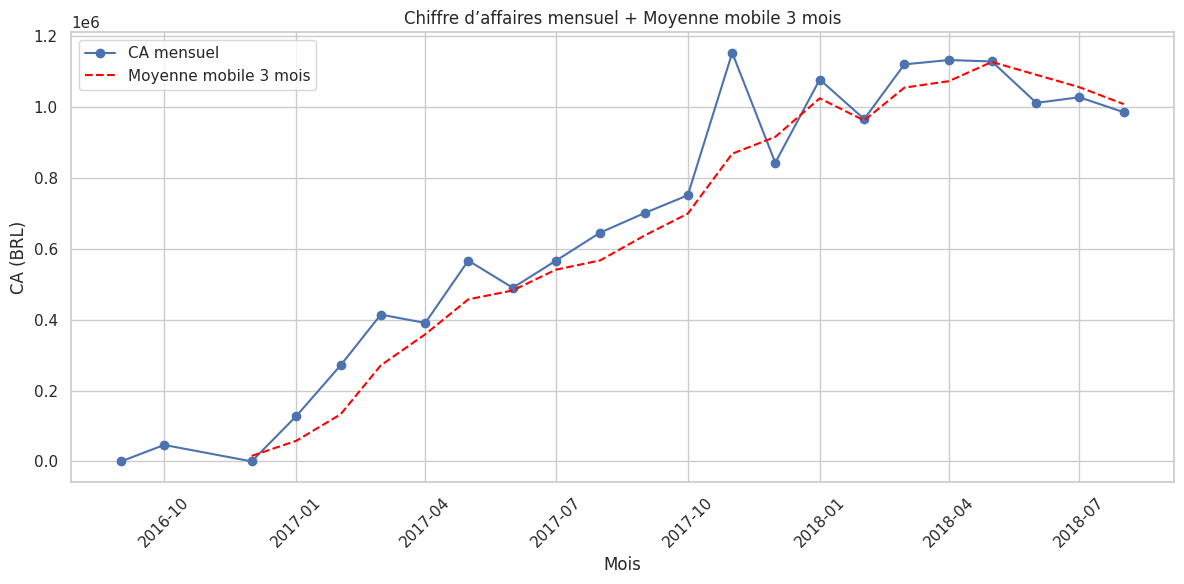

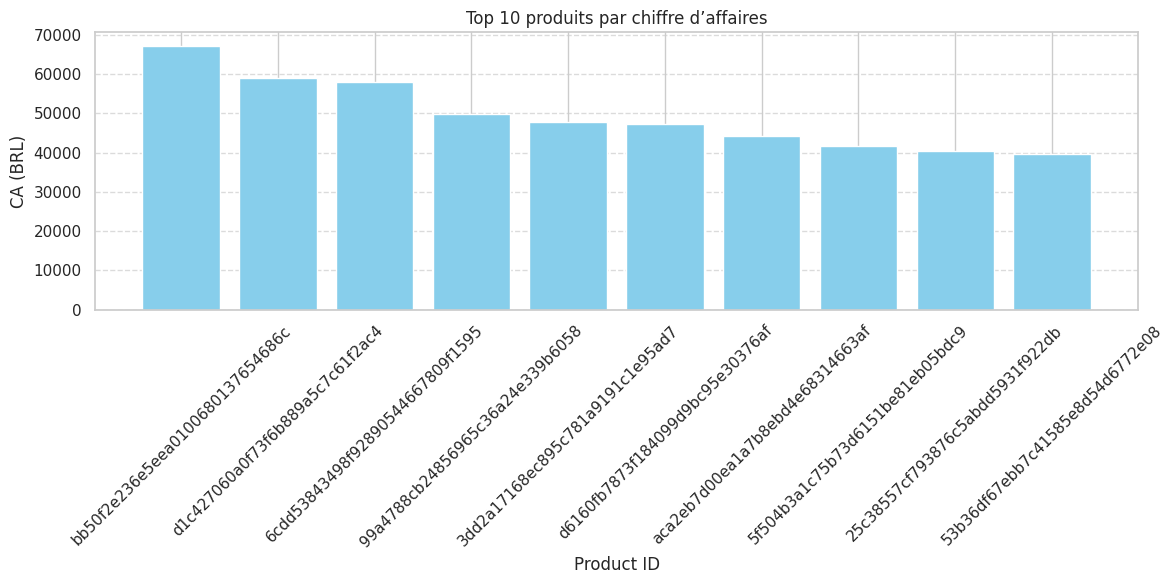

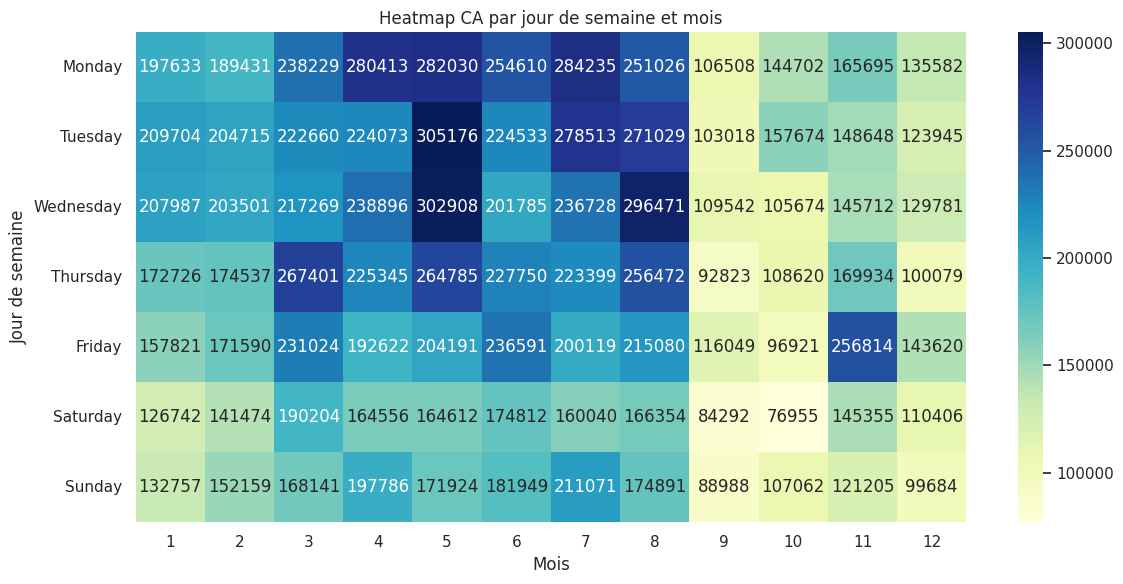

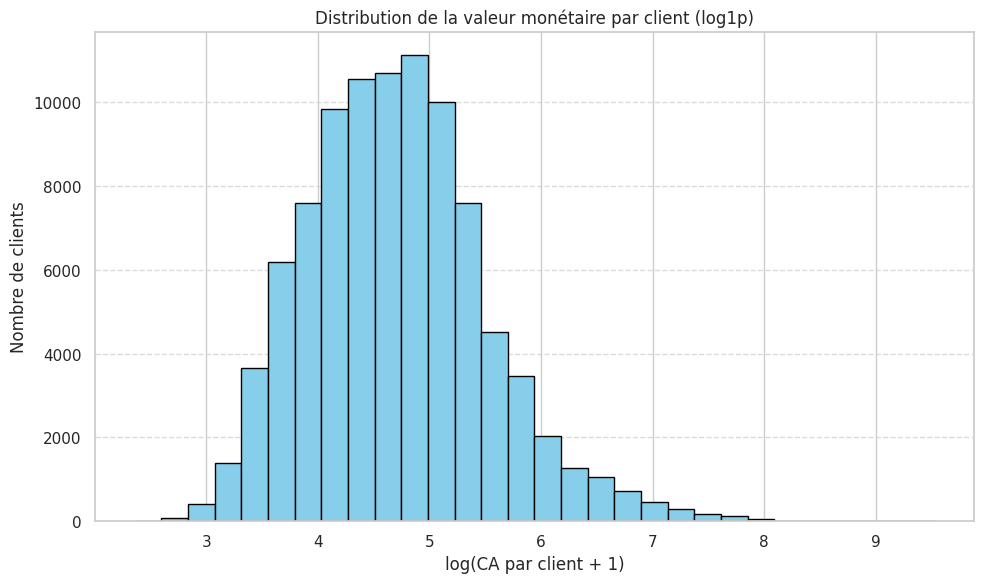

In [ ]:
# 5. Visualisation (Graphiques)
visualize_data(kpis)